In [3]:
from IPython.display import display
import numpy as np
import pandas as pd
import mxfusion as mf
import mxnet as mx
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

In [4]:
# Plotting functions
def plot_reconstruction(ax1, ax2, x, r, z):
    ax1.plot(range(len(x)), x, range(len(x)), r)
    ax1.legend(["original", "reconstruction"])
    ax1.set_title(f'Reconstrunction error {np.sqrt(np.linalg.norm(x - r)):.3f}')
    ax2.stem(range(len(z)), z)
    ax2.set_ylim([-0.1, 0.1])

(7802, 150)
(7802, 1)


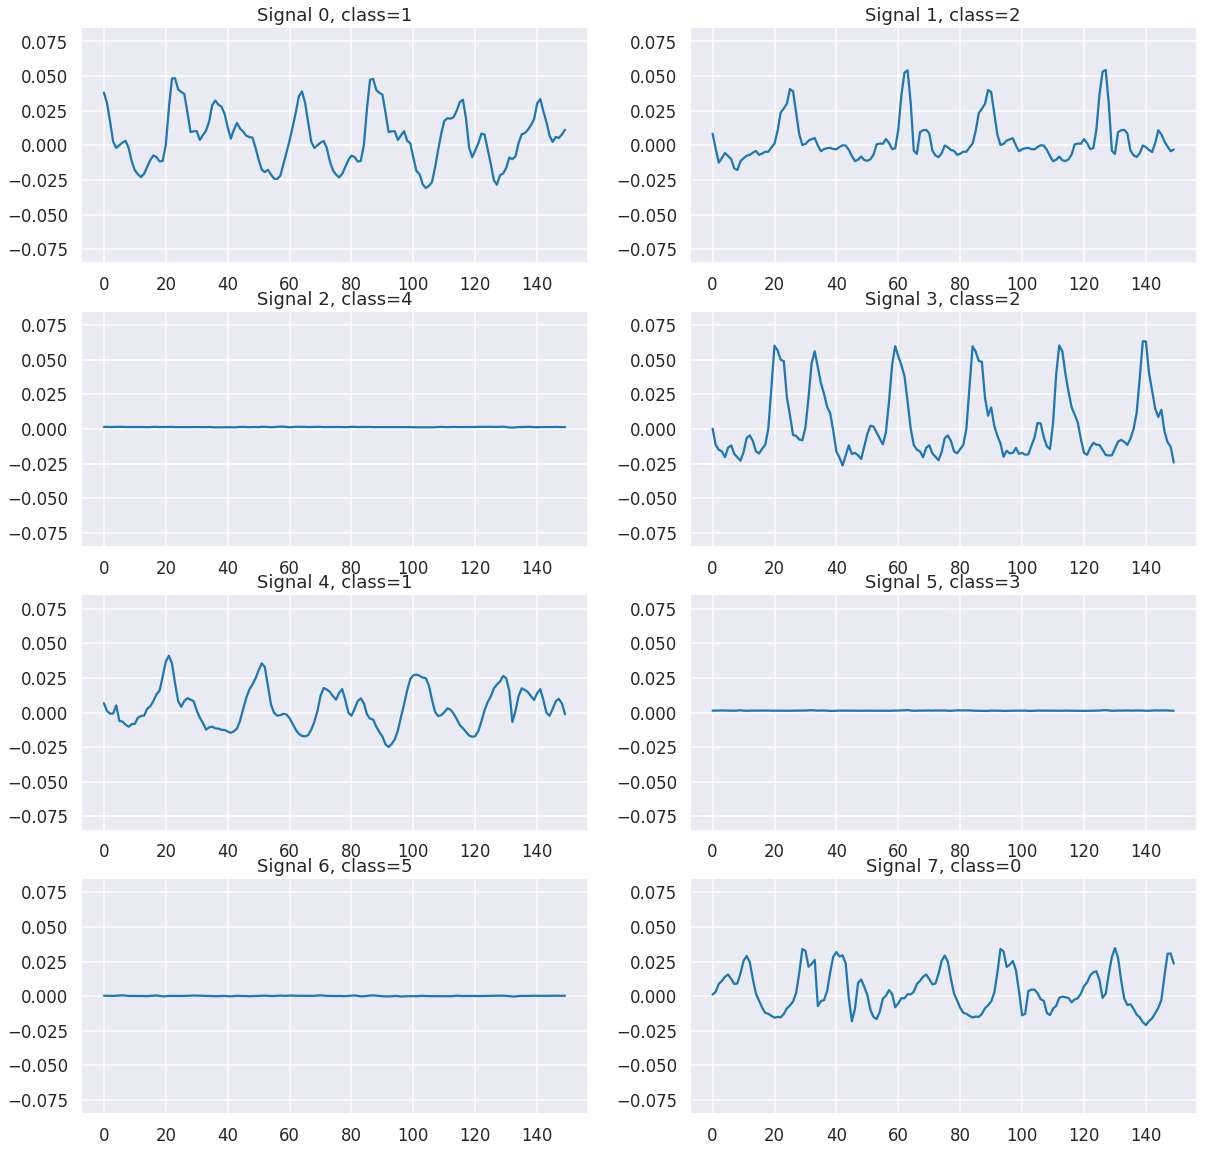

In [5]:
data = loadmat('data.mat')
x_train = data['train_x']
y_train = data['train_y'].T
x_test = data['test_x']
y_test = data['test_y'].T
[m_train, n] = x_train.shape
m_test = x_test.shape[0]
print(x_train.shape)
print(y_train.shape)

# Standardize data
# scaler = StandardScaler().fit(x_train)
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

norms = np.linalg.norm(x_train, axis=0)
x_train = x_train / norms
x_test = x_test / norms

minmax = np.max(np.abs(x_train))

fig, axs = plt.subplots(4, 2, figsize=(20, 20))
axs = axs.flatten()
for i in range(len(axs)):
    sns.lineplot(ax=axs[i], data=x_train[i, :])
    # sns.lineplot(ax=axs[i], data=D[i, :])
    axs[i].set_ylim([-minmax, minmax])
    axs[i].set_title(f'Signal {i}, class={y_train[i, 0]}')
    
df_train = pd.DataFrame(np.hstack([x_train, y_train]), columns=tuple(map(str, range(x_train.shape[1]))) + ('y',))
# display(df_train.head())
df1_train = df_train[df_train['y'] == 1].drop('y', inplace=False, axis=1)
# display(df1_train.head())

df_test = pd.DataFrame(np.hstack([x_test, y_test]), columns=tuple(map(str, range(x_test.shape[1]))) + ('y',))
# display(df_test.head())
df1_test = df_test[df_test['y'] == 1].drop('y', inplace=False, axis=1)
# display(df1_test.head())

In [6]:
k = 256
dico = MiniBatchDictionaryLearning(n_components=k, alpha=0.1, n_iter=500)
# dico = DictionaryLearning(n_components=k, alpha=0.1)
D = dico.fit(df1_train).components_

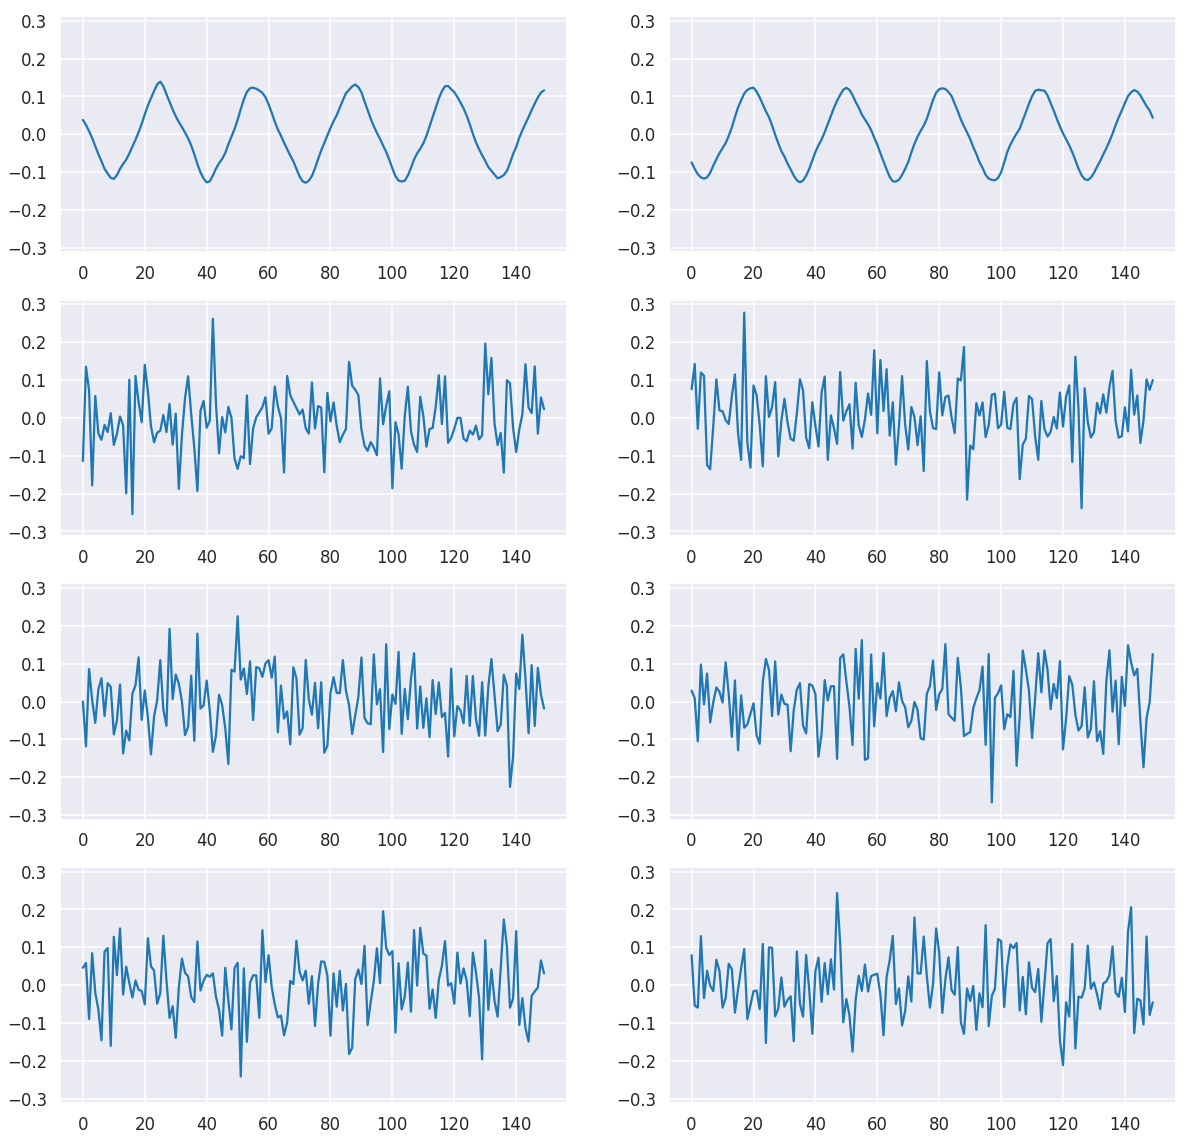

In [7]:
# Print some of the bases
dminmax = np.max(np.abs(D))
fig, axs = plt.subplots(4, 2, figsize=(20, 20))
axs = axs.flatten()
for i in range(len(axs)):
    sns.lineplot(ax=axs[i], data=D[i, :])
    axs[i].set_ylim([-dminmax, dminmax])

In [8]:
# Reconstruct it frame-by-frame using a linear combination of 20 atoms per frame (sparsity-constrained OMP)
from sklearn.decomposition import SparseCoder
coder = SparseCoder(dictionary=D, transform_n_nonzero_coefs=20, transform_alpha=None, transform_algorithm="omp")
Z = coder.transform(df1_test)
reconstructions = np.dot(Z, D)

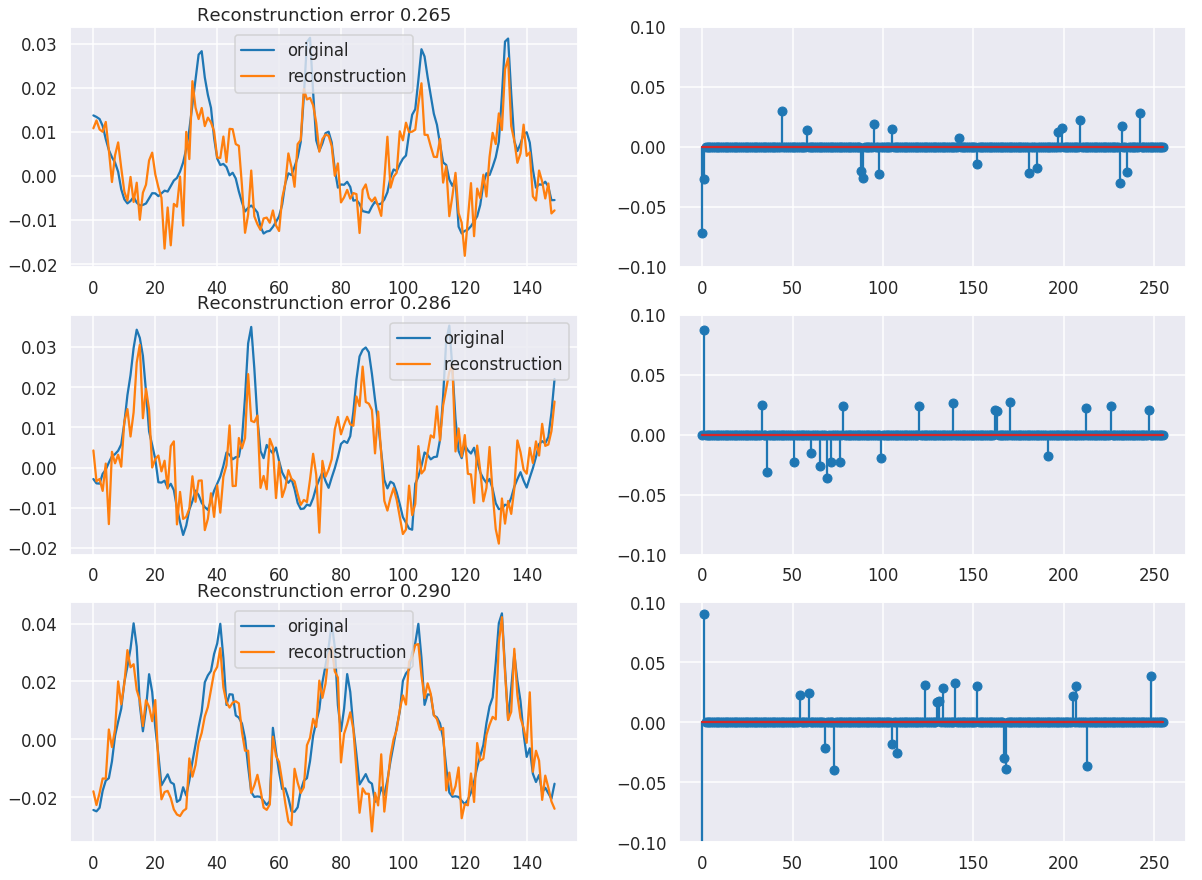

In [9]:
# Plot a couple of reconstructions along with the coefficient vectors
idxs = [0, 10, 100]

fig, axs = plt.subplots(len(idxs), 2, figsize=(20, 5 * len(idxs)))
axs = axs.flatten()

for i, idx in enumerate(idxs):
    plot_reconstruction(axs[2 * i], axs[2 * i + 1], df1_test.values[idx, :], reconstructions[idx, :], Z[idx, :])

In [4]:
# MXFusion model
from mxfusion import Model, Variable
from mxfusion.components.distributions import Normal, MultivariateNormal
from mxfusion.components.variables import PositiveTransformation
from mxfusion.components.functions import MXFusionGluonFunction

k = 256
[m, n] = df1_train.values.shape
print(f"m: {m}, n: {n}, k: {k}")

# zero = mx.nd.array([0])
# one = mx.nd.array([1])
model = Model()

sizes_as_variables = False
operator_dot = False
full_covariance = True

if sizes_as_variables:
    model.n = Variable()
    model.k = Variable()
    model.m = Variable()
else:
    model.n = n
    model.k = k
    model.m = m
    
D_init = mx.nd.array(np.random.randn(k, n))

if operator_dot:
    from mxfusion.components.functions.operators import dot
else:
    from mxnet.gluon import nn
    dot = nn.HybridLambda(function='dot')
    model.dot = MXFusionGluonFunction(dot, num_outputs=1, broadcastable=False)
    dot = model.dot
    
if full_covariance:
    cov = mx.nd.broadcast_to(mx.nd.expand_dims(mx.nd.array(np.eye(model.k)), 0), shape=(model.m, model.k, model.k))
    model.Z = MultivariateNormal.define_variable(mean=mx.nd.zeros(shape=(model.m, model.k)), covariance=cov, shape=(model.m, model.k))
else:
    model.Z = Normal.define_variable(mean=0, variance=1, shape=(model.m, model.k))
    
# model.D = Variable(shape=(model.k, model.n), initial_value=D_init)
model.D = Normal.define_variable(mean=0, variance=1, shape=(model.k, model.n))
sigma_2 = Variable(shape=(1,), transformation=PositiveTransformation())
model.X = Normal.define_variable(mean=dot(model.Z, model.D), variance=sigma_2, shape=(model.m, model.n))

NameError: name 'df1_train' is not defined

In [ ]:
from mxfusion.inference import StochasticVariationalInference
from mxfusion.inference.grad_based_inference import GradBasedInference
from mxfusion.inference import BatchInferenceLoop
from mxfusion.inference.meanfield import create_Gaussian_meanfield
from mxfusion.models import Model, Posterior

if sizes_as_variables:
    observed = [model.X, model.m, model.k, model.n]
else:
    observed = [model.X]
q = create_Gaussian_meanfield(model=model, observed=observed)

print(model.X.shape)

svi = StochasticVariationalInference(model=model, num_samples=100, observed=observed, posterior=q)
infr = GradBasedInference(inference_algorithm=svi, grad_loop=BatchInferenceLoop())
if sizes_as_variables:
    infr.run(X=mx.nd.array(df1_train.values), m=mx.nd.array([m]), k=mx.nd.array([k]), n=mx.nd.array([n]), max_iter=10)
else:
    infr.run(X=mx.nd.array(df1_train.values), max_iter=10)

In [168]:
for v in q.variables.values():
    print(v, v.shape, v.successors)

Variable Z (113eb) (7802, 256) []
Variable (5c1fe) (7802, 256) [('mean', Normal(mean=Variable (5c1fe), variance=Variable (f9554)))]
Variable (f9554) (7802, 256) [('variance', Normal(mean=Variable (5c1fe), variance=Variable (f9554)))]
Variable D (67b4b) (256, 150) []
Variable (c293e) (256, 150) [('mean', Normal(mean=Variable (c293e), variance=Variable (66c3f)))]
Variable (66c3f) (256, 150) [('variance', Normal(mean=Variable (c293e), variance=Variable (66c3f)))]
